## Import DataSet and Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/AB_NYC_2019.csv')

In [2]:
df_5 = df[['neighbourhood_group','room_type','number_of_reviews','reviews_per_month','availability_365']]
print(df_5.head())
print(df_5.shape)

  neighbourhood_group        room_type  number_of_reviews  reviews_per_month  \
0            Brooklyn     Private room                  9               0.21   
1           Manhattan  Entire home/apt                 45               0.38   
2           Manhattan     Private room                  0                NaN   
3            Brooklyn  Entire home/apt                270               4.64   
4           Manhattan  Entire home/apt                  9               0.10   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0  
(48895, 5)


## EDA

In [3]:
top_neighbourhood_groups = df['neighbourhood_group'].value_counts()
print(top_neighbourhood_groups)
print()
print(df['room_type'].value_counts())
print("free Airbnb ", sum(df['price'] == 0))

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64
free Airbnb  11


Text(0.5, 0, 'Neighbourhood names')

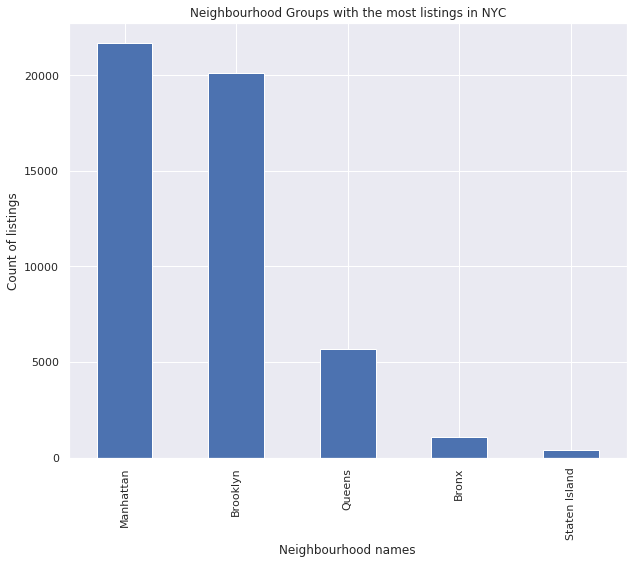

In [4]:
sns.set(rc={'figure.figsize':(10,8)})
vis_1 = top_neighbourhood_groups.plot(kind = 'bar')
vis_1.set_title("Neighbourhood Groups with the most listings in NYC")
vis_1.set_ylabel("Count of listings")
vis_1.set_xlabel("Neighbourhood names")

In [5]:
## Get the DataFrame for EDA: eda_df
label = df['price'].copy()
eda_df = df.copy()
eda_label = pd.DataFrame(np.log(label.values), columns=['log price'])
eda_df.drop(columns=['price'],inplace=True)
eda_df = pd.concat([eda_df, eda_label], axis=1)
print(eda_df.head())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  minimum_nights  number_of_reviews last_review  \
0     Private room               1                  9  2018-10-19   
1 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


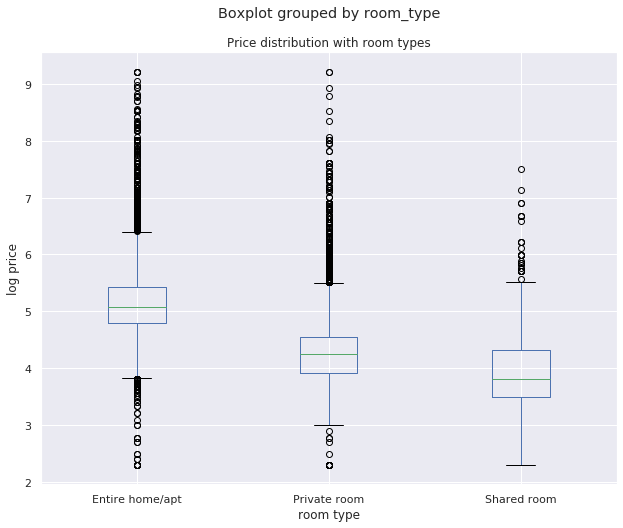

In [6]:
eda_df[['log price','room_type']].boxplot(by='room_type')
plt.title('Price distribution with room types')
plt.ylabel('log price')
plt.xlabel("room type")
plt.show()

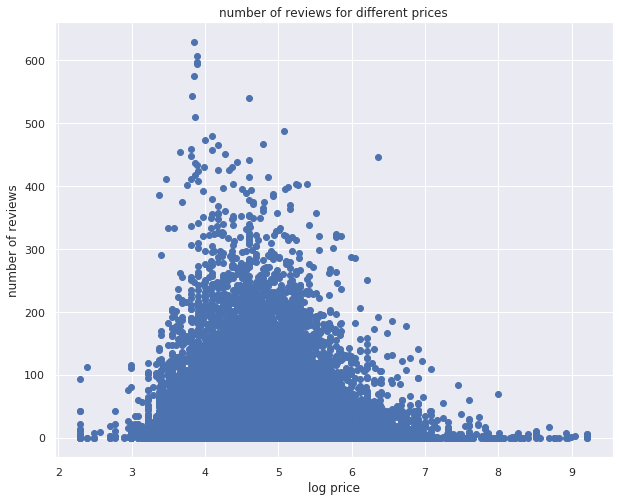

In [7]:
plt.scatter(eda_df['log price'],eda_df['number_of_reviews'])
plt.title("number of reviews for different prices")
plt.xlabel("log price")
plt.ylabel("number of reviews")
plt.show()

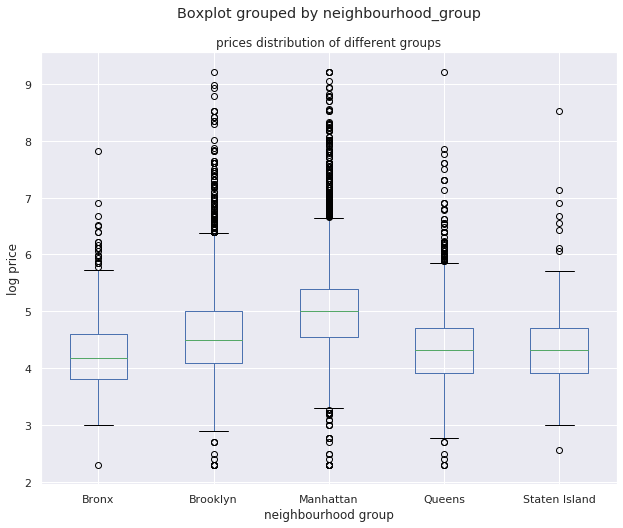

In [8]:
eda_df[['log price','neighbourhood_group']].boxplot(by='neighbourhood_group')
plt.xlabel("neighbourhood group")
plt.ylabel('log price')
plt.title("prices distribution of different groups")
plt.show()

## Preprocessing Data

In [9]:
cat_ftrs = ['neighbourhood_group']
ordinal_ftrs = ['room_type']
ordinal_cats = [['Entire home/apt','Private room','Shared room']]
num_ftrs = ['number_of_reviews', 'reviews_per_month']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=RandomForestRegressor(),random_state=3)),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('num', numeric_transformer, num_ftrs)])

In [10]:
X_prep = preprocessor.fit_transform(df_5)
feature_names = list(preprocessor.named_transformers_['cat'][0].get_feature_names()) +\
                preprocessor.transformers_[1][-1] +\
                preprocessor.transformers_[2][-1]
print(feature_names)

['x0_Bronx', 'x0_Brooklyn', 'x0_Manhattan', 'x0_Queens', 'x0_Staten Island', 'room_type', 'number_of_reviews', 'reviews_per_month']


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
df_preprocessed = pd.DataFrame(data=X_prep,columns=feature_names)
label = df['price'].copy()
label[label <= 100] = 0
label[label > 100] = 1
price = pd.DataFrame(label, columns=['price'])
df1_preprocessed = pd.concat([df_preprocessed, price], axis=1)
print(df1_preprocessed.head())
print(len(df1_preprocessed))
# result for ML Pipeline is called df1_preprocessed

   x0_Bronx  x0_Brooklyn  x0_Manhattan  x0_Queens  x0_Staten Island  \
0       0.0          1.0           0.0        0.0               0.0   
1       0.0          0.0           1.0        0.0               0.0   
2       0.0          0.0           1.0        0.0               0.0   
3       0.0          1.0           0.0        0.0               0.0   
4       0.0          0.0           1.0        0.0               0.0   

   room_type  number_of_reviews  reviews_per_month  price  
0        1.0          -0.320414          -0.600217      1  
1        0.0           0.487665          -0.491387      1  
2        1.0          -0.522433          -0.558200      1  
3        0.0           5.538156           2.235780      0  
4        0.0          -0.320414          -0.670637      0  
48895


## Classification EDA

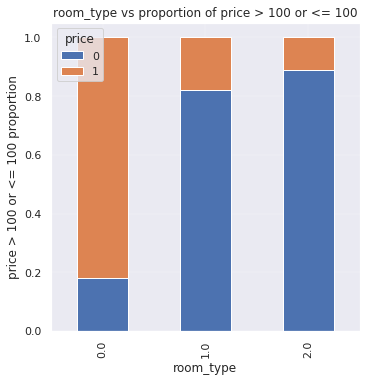

In [27]:
plt.figure(figsize=(15,15))
eda_feature_names = ['room_type']

plot_number = 1
for col in eda_feature_names:
    count_matrix=df1_preprocessed.groupby([col,'price']).size().unstack()
    count_matrix_norm=count_matrix.div(count_matrix.sum(axis=1),axis=0)
    
    ax = plt.subplot(3, 3, plot_number)
    count_matrix_norm.plot(kind='bar', stacked=True, ax=ax)
    ax.grid(linewidth=0.25)
    ax.set_title(col + " vs proportion of price > 100 or <= 100")
    ax.set_ylabel("price > 100 or <= 100 proportion")
    plot_number = plot_number + 1
plt.tight_layout()

## Get the Baseline Accuracy

In [12]:
## Find the balance
y = df1_preprocessed['price']
print(y.value_counts()/y.shape)

1    0.510625
0    0.489375
Name: price, dtype: float64


## Machine Learning Pipeline and Cross Validation

In [13]:
y = df1_preprocessed['price'].values
df1_preprocessed.drop(columns=['price'],inplace=True)
X = df1_preprocessed
print(X.head())

   x0_Bronx  x0_Brooklyn  x0_Manhattan  x0_Queens  x0_Staten Island  \
0       0.0          1.0           0.0        0.0               0.0   
1       0.0          0.0           1.0        0.0               0.0   
2       0.0          0.0           1.0        0.0               0.0   
3       0.0          1.0           0.0        0.0               0.0   
4       0.0          0.0           1.0        0.0               0.0   

   room_type  number_of_reviews  reviews_per_month  
0        1.0          -0.320414          -0.600217  
1        0.0           0.487665          -0.491387  
2        1.0          -0.522433          -0.558200  
3        0.0           5.538156           2.235780  
4        0.0          -0.320414          -0.670637  


In [14]:
print(y)

[1 1 1 ... 1 0 0]


In [15]:
#y = df1_preprocessed['price'].values
#df1_preprocessed.drop(columns=['price'],inplace=True)
#X = df1_preprocessed.values
#print(X)
#print(y.shape)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

## RF

In [17]:
from sklearn.ensemble import RandomForestClassifier
def ML_pipeline_kfold_GridSearchCV_RF(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: supervised ML method
    pipe = make_pipeline(RandomForestClassifier(n_estimators =  100,random_state=random_state))
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [10,30,100,300],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True, iid=True, n_jobs=-1, verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [18]:
grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_RF(X,y,42,4)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.3min finished


In [19]:
print("Best set of hyperparameters chosen by CV is ", grid.best_params_)
print("Best average score of all sets of folds of the best set of hyperparameter is ", grid.best_score_)
print("Use the best set of hyperparameter, we apply to test set, we get test score is ", score)

Best set of hyperparameters chosen by CV is  {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 128}
Best average score of all sets of folds of the best set of hyperparameter is  0.8229880355864608
Use the best set of hyperparameter, we apply to test set, we get test score is  0.8208405767460886


## Model Inspection

In [20]:
import shap

In [21]:
shap.initjs()
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[0]) #first step in the pipline: random forest classifier
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test[:1000])
print(np.shape(shap_values))

(2, 1000, 8)


In [22]:
print(X_test.values[5,:].shape)

(8,)


In [23]:
print(X_test[:10])

       x0_Bronx  x0_Brooklyn  x0_Manhattan  x0_Queens  x0_Staten Island  \
18356       0.0          0.0           1.0        0.0               0.0   
9598        0.0          0.0           1.0        0.0               0.0   
43112       0.0          0.0           1.0        0.0               0.0   
17696       0.0          1.0           0.0        0.0               0.0   
41455       0.0          0.0           1.0        0.0               0.0   
24995       0.0          1.0           0.0        0.0               0.0   
28812       0.0          0.0           1.0        0.0               0.0   
15974       0.0          0.0           1.0        0.0               0.0   
7642        0.0          0.0           1.0        0.0               0.0   
26737       0.0          0.0           1.0        0.0               0.0   

       room_type  number_of_reviews  reviews_per_month  
18356        0.0          -0.432647          -0.651432  
9598         0.0          -0.095947          -0.459378  
431

In [24]:
print(y_test[:10])

[1 1 1 1 1 1 1 0 0 1]


In [25]:
index = 1 # the index of the point to explain (different individuals)
print(explainer.expected_value[1]) # we explain class 1 predictions - baseline value
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = X_test.values[index,:],feature_names = feature_names)

0.5108771346763473


In [26]:
ftr = 'room_type'

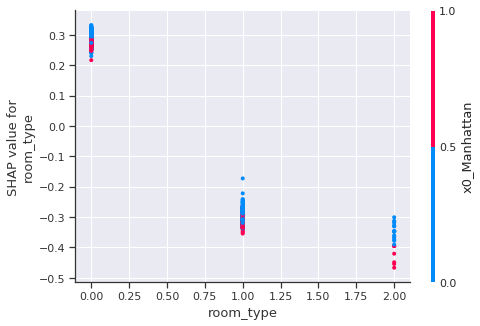

In [27]:
# shap value contributes highly in the observations of room_type = 0
shap.dependence_plot(ftr, shap_values[1], X_test.values[:1000], feature_names=feature_names)

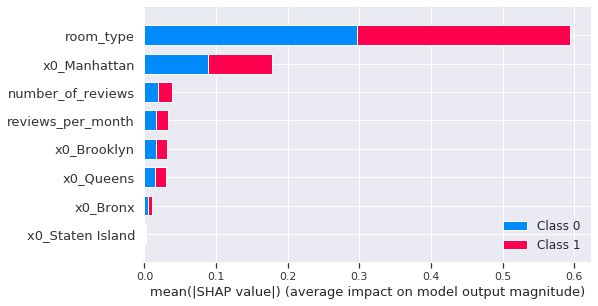

In [28]:
shap.summary_plot(shap_values, X_test.values[:1000],feature_names = feature_names)

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_GridSearchCV_LR(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    pipe = make_pipeline(LogisticRegression())
    # the parameter(s) we want to tune
    parameter_space = {'logisticregression__penalty': ['l1', 'l2'],
                       'logisticregression__C': np.logspace(0, 4, 10)}
    # prepare gridsearch
    lr_clf = GridSearchCV(pipe, parameter_space, scoring = make_scorer(accuracy_score),
                          cv=kf, return_train_score = True, iid=True, n_jobs=-1, verbose=10)
    # do kfold CV on _other
    lr_clf.fit(X_other, y_other)
    return lr_clf, lr_clf.score(X_test, y_test), X_test, y_test

In [71]:
grid_lr, score_lr, X_test, y_test = ML_pipeline_kfold_GridSearchCV_LR(X,y,42,4)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.7s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [73]:
print("Best set of hyperparameters chosen by CV is ", grid_lr.best_params_)
print("Best average score of all sets of folds of the best set of hyperparameter is ", grid_lr.best_score_)
print("Use the best set of hyperparameter, we apply to test set, we get test score is ", score_lr)

Best set of hyperparameters chosen by CV is  {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
Best average score of all sets of folds of the best set of hyperparameter is  0.8225023008487575
Use the best set of hyperparameter, we apply to test set, we get test score is  0.8224767358625626


## Below are future things to try

## NN mini example

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(34226, 8)
(14669, 8)
(34226,)


In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [14]:
print(predict_train[:10])

[1 0 0 1 0 1 1 1 0 0]


In [15]:
print(y_train[:10])

[1 0 0 1 0 0 1 1 0 0]


In [16]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, predict_train))

0.8234967568515164


## NN Trial

In [95]:
from sklearn.neural_network import MLPClassifier
def ML_pipeline_kfold_GridSearchCV_NN(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation="relu", max_iter=100)
    # the parameter(s) we want to tune
    parameters={
                'mlpclassifier__alpha': [10.0 ** -np.arange(1, 7)],
                'mlpclassifier__solver': ['adam', 'sgd']
               }
    # prepare gridsearch
    clf = GridSearchCV(mlp, parameters, n_jobs=-1, cv=kf, verbose=10, return_train_score = True, scoring = make_scorer(accuracy_score))
    # do kfold CV on _other
    clf.fit(X_other, y_other)
    return clf, clf.score(X_test, y_test), X_test, y_test

In [96]:
grid_nn, score_nn, X_test, y_test = ML_pipeline_kfold_GridSearchCV_NN(X,y,42,4)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s


ValueError: Invalid parameter mlpclassifier for estimator MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [90]:
print("Best set of hyperparameters chosen by CV is ", grid_nn.best_params_)
print("Best average score of all sets of folds of the best set of hyperparameter is ", grid_nn.best_score_)
print("Use the best set of hyperparameter, we apply to test set, we get test score is ", score_nn)

NameError: name 'grid_nn' is not defined

## SVC

In [ ]:
from sklearn.svm import SVC
def ML_pipeline_kfold_GridSearchCV_SVC(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    pipe = make_pipeline(SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-3,4,num=4),'svc__gamma': np.logspace(-3,4,num=4)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True, iid=True, n_jobs=-1, verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [ ]:
grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_SVC(X,y,42,4)

In [ ]:
print("Best set of hyperparameters chosen by CV is ", grid.best_params_)
print("Best average score of all sets of folds of the best set of hyperparameter is ", grid.best_score_)
print("Use the best set of hyperparameter, we apply to test set, we get test score is ", score)

In [ ]:
print(score)